## El mejor RF Classifier

Vamos a simplemente encontrar con todo lo que sabemos hasta ahora el RF que mejor clasifica protones de gammas a partir de datos simulados por MonteCarlo

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Distribución del clasificador
import scipy.stats as stats

# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=200000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=200000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
    
df_protongamma.insert(6,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]

/tmp/ipykernel_3331/745807637.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

nest = []
maxdep = []
accur = []
auc = []

n0_estimators = 50
for i in range(10):
    max0_depth = 3
    for j in range(15):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        auci = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
        accuracy = accuracy_score(y_test, rf.predict(X_test))
        nest.append(n0_estimators)
        maxdep.append(max0_depth)
        accur.append(accuracy)
        auc.append(auci)
        max0_depth = max0_depth + 2
        print(accuracy)
    n0_estimators = n0_estimators + 25
    print()

0.6916216600341103
0.7323763501989767
0.755187606594656
0.772562535531552
0.784216884593519
0.7903638430926663
0.7931353041500853
0.7916785105173394
0.7911100056850483
0.7896532120523024
0.7884806708357021
0.7901861853325753
0.7884806708357021
0.7879476975554293
0.7870594087549744

0.6900582717453099
0.7227472996020466
0.7561824900511654
0.7745167708925526
0.7861355884025014
0.7898664013644116
0.7924602046617396
0.7918206367254121
0.7908968163729392
0.7912876634451392
0.7899019329164297
0.7907546901648664
0.7919982944855031
0.7889781125639568
0.7863843092666287

0.6908754974417283
0.7230315520181921
0.7566088686753838
0.772740193291643
0.785496020466174
0.7904349061967026
0.7918916998294485
0.7921404206935759
0.7918206367254121
0.7911455372370665
0.7914297896532121
0.7926733939738487
0.7915363843092666
0.7916429789653212
0.7894400227401933

0.6905201819215463
0.733726549175668
0.7546901648664014
0.7748010233086982
0.7852828311540648
0.7895110858442297
0.7927444570778852
0.7933129619101

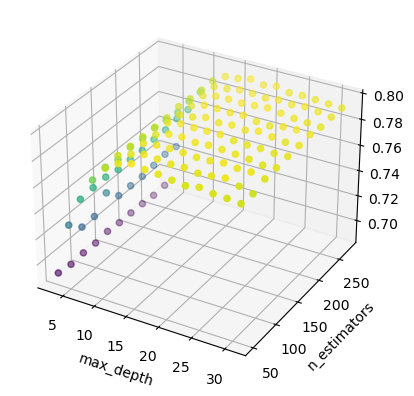

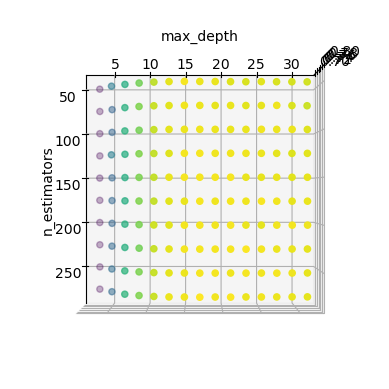

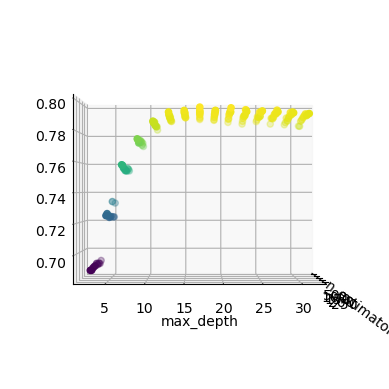

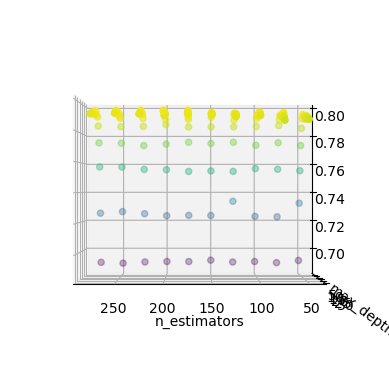

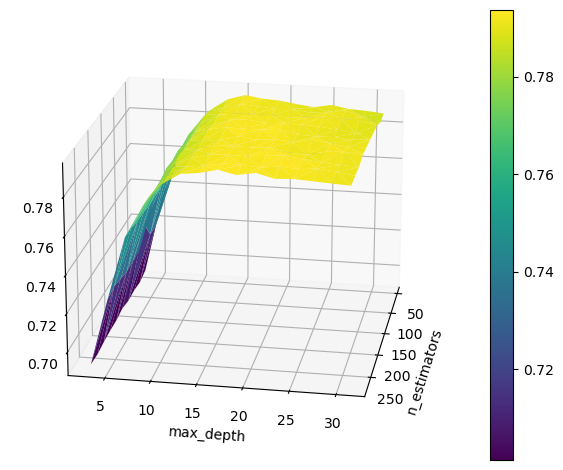

In [9]:
# Representamos los resultados para ver gráficamente la precisión del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, accur, c=accur, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(20, 10)
plt.show()

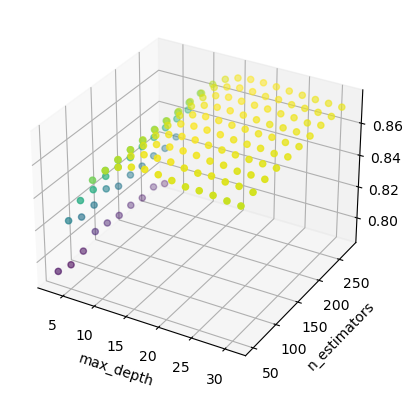

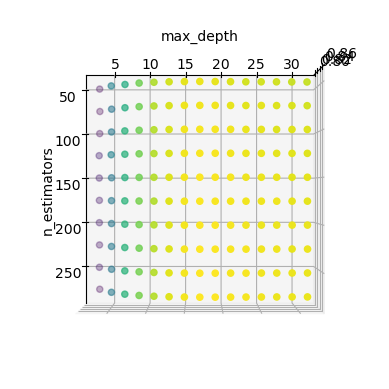

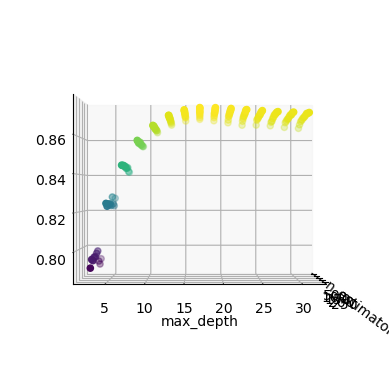

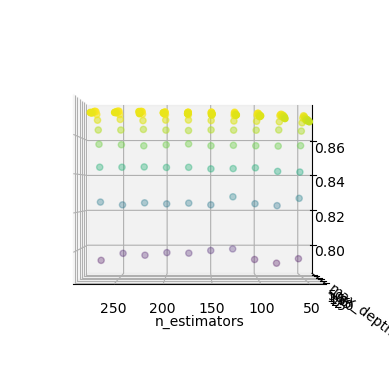

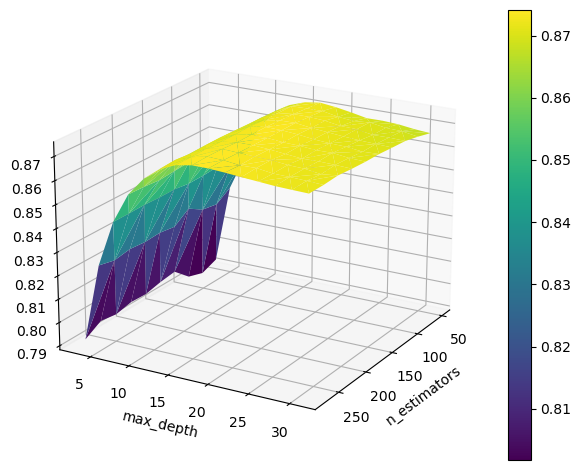

In [6]:
# Representamos los resultados para ver gráficamente la AUC del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, auc, c=auc, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, auc, c=auc, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, auc, c=auc, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, auc, c=auc, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, auc, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(20, 30)
plt.show()

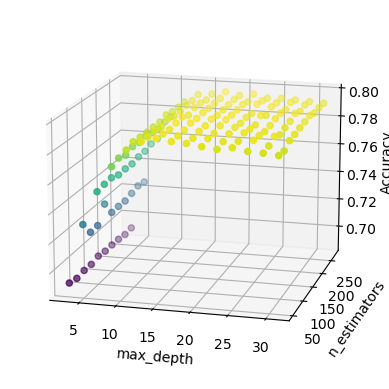

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(maxdep, nest, accur, c=accur, cmap='viridis')
ax.view_init(15, -75)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Accuracy')
plt.show()

fig.savefig('Accur_Clas.png')

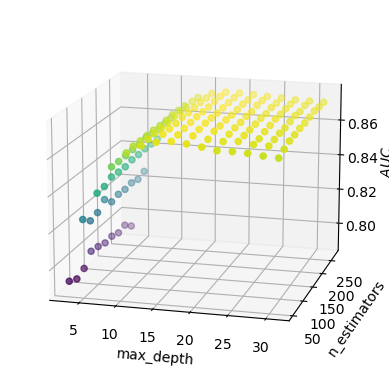

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(maxdep, nest, auc, c=auc, cmap='viridis')
ax.view_init(15, -75)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('$AUC$')
plt.show()

fig.savefig('AUC.png')

Ambos resultados son muy similares, otorgando valores del máximo alcanzados para max_depth $\approx$ 19 y que crece ligeramente con n_estimators pero que para $\approx$ 150 los resultados son máximos.

Vamos a cargar nuevas imágenes y observar los resultados que nos dan con el mejor clasificador que hemos obtenido:

In [2]:
# Cargamos imágenes
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=200000, stop=800000)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=200000, stop=800000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]
print(df_protons.shape)

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]
print(df_gamma.shape)

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
    
df_protongamma.insert(6,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]

(154781, 6)
(182791, 6)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfh = RandomForestClassifier(max_depth=19, n_estimators=150)
rfh.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

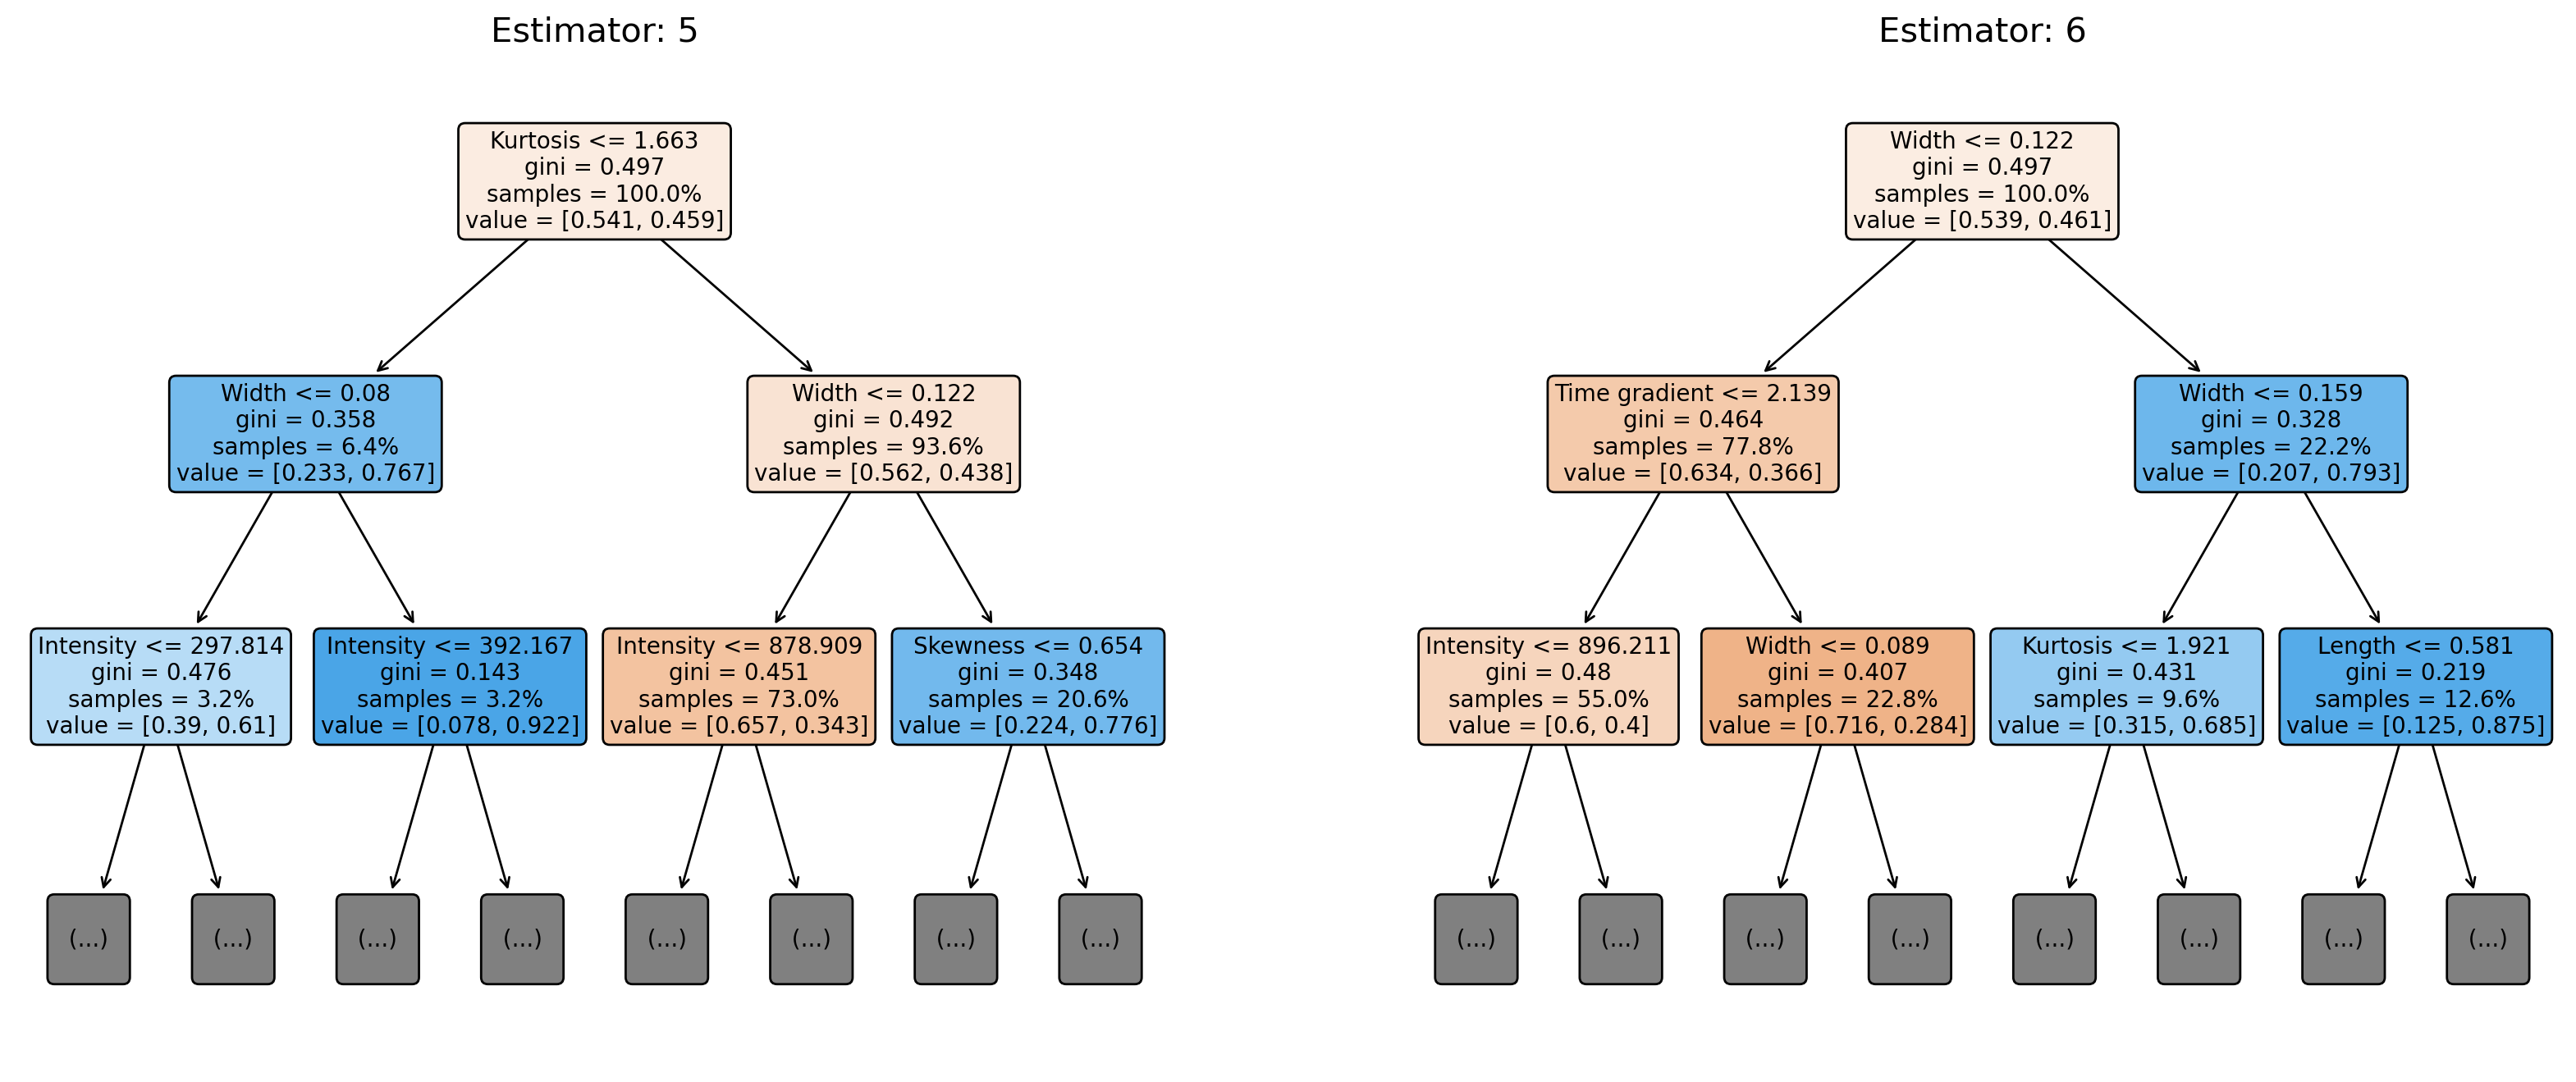

In [22]:
from sklearn.tree import export_graphviz
from sklearn import tree

names = ['Intensity', 'Skewness', 'Kurtosis', 'Length', 'Width', 'Time gradient']

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8), dpi=200)
for index in range(5, 7):
    tree.plot_tree(rfh.estimators_[index],
                   feature_names = names,
                   filled=True,
                   impurity=True, 
                   proportion=True,
                   ax = axes[index-5],
                   max_depth = 2,
                   fontsize=10,  # Tamaño de fuente
                   rounded=True  # Bordes redondeados
                  )

    axes[index-5].set_title('Estimator: ' + str(index), fontsize = 15)
    
fig.savefig('rf_5trees.png')

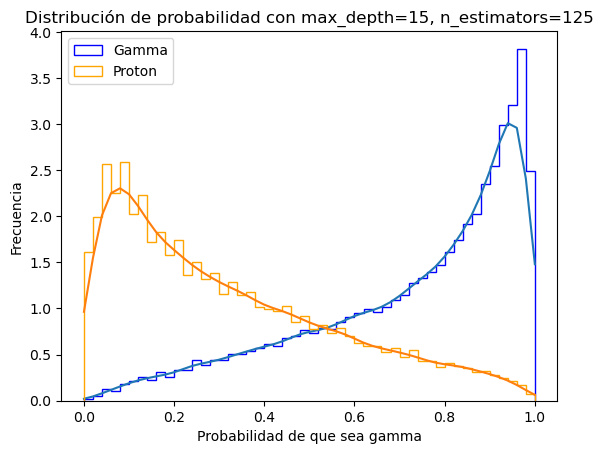

In [17]:
y_pred = (rf.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_gamma = proba[label == 0]
prob_proton = proba[label == 1]

densityg = stats.gaussian_kde(prob_gamma)
ng, xg, _ = plt.hist(prob_gamma, bins=50, density=True, histtype=u'step', color = 'blue', label='Gamma')  
plt.plot(xg, densityg(xg))

densityph = stats.gaussian_kde(prob_proton)
npr, xp, _ = plt.hist(prob_proton, bins=50, density=True, histtype=u'step', color = 'orange', label='Proton')  
plt.plot(xp, densityph(xp))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea gamma")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

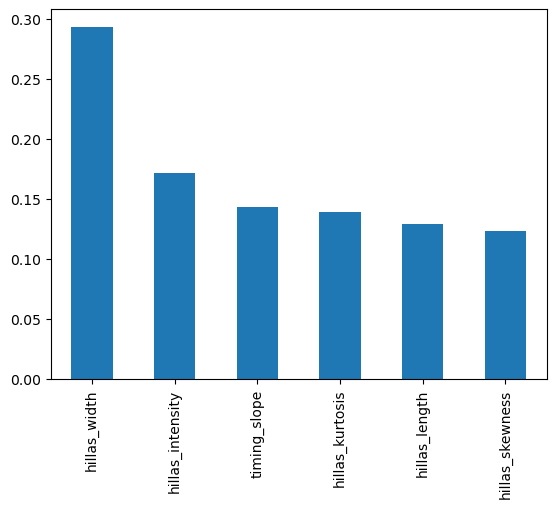

In [18]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

In [21]:
thresholds = np.arange(0, 1.01, 0.01)

# Creamos los arrays que van a representar nuestros valores:
TP = []
FN = []
FP = []
TN = []
total = []
TPRp=[]                                                                       # Para protones
FPRp=[]
TPRg=[]                                                                       # Para gammas
FPRg=[]
accuracy = []

for threshold in thresholds:
    y_pred = (rf.predict_proba(X_test)[:,1]>threshold).astype("float")
    cm = confusion_matrix(y_test, y_pred)
    
    TPi=cm[1,1]
    FNi=cm[1,0]
    FPi=cm[0,1]
    TNi=cm[0,0]
    totali = TPi + TNi + FNi + FPi
    TPRpi=TPi/(TPi+FNi)
    FPRpi=FPi/(FPi+TNi)
    TPRgi=TNi/(TNi+FPi)
    FPRgi=FNi/(FNi+TPi)
    accuracyi = accuracy_score(y_test, y_pred)
    if abs(TPi-TNi) < 300:                                                       # Deveulve el umbral para cual se maximizan el número de TP Y TN
        print("Umbral que maximiza TP y TN:", threshold)
    elif abs(FPi-FNi) < 300:                                                     # Deveulve el umbral para cual se minimizan el número de FP Y FN
        print("Umbral que minimiza FP y FN:", threshold)
    elif abs(TPRpi-TPRgi) < 0.05:                                               # Deveulve el umbral para cual la curva ROC se tuerce
        print("Umbral mejor según ROC:", threshold)                         
    TP.append(TPi)
    FN.append(FNi)
    FP.append(FPi)
    TN.append(TNi)
    total.append(totali)
    TPRp.append(TPRpi)
    FPRp.append(FPRpi)
    TPRg.append(TPRgi)
    FPRg.append(FPRgi)
    accuracy.append(accuracyi)
print("Umbral que maximiza la precisión:", accuracy.index(max(accuracy))/100)

Umbral que maximiza TP y TN: 0.39
Umbral mejor según ROC: 0.45
Umbral mejor según ROC: 0.46
Umbral mejor según ROC: 0.47000000000000003
Umbral mejor según ROC: 0.48
Umbral mejor según ROC: 0.49
Umbral que minimiza FP y FN: 0.5
Umbral que maximiza la precisión: 0.53


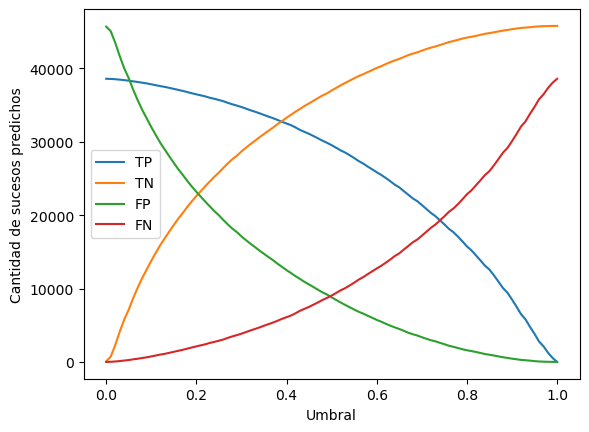

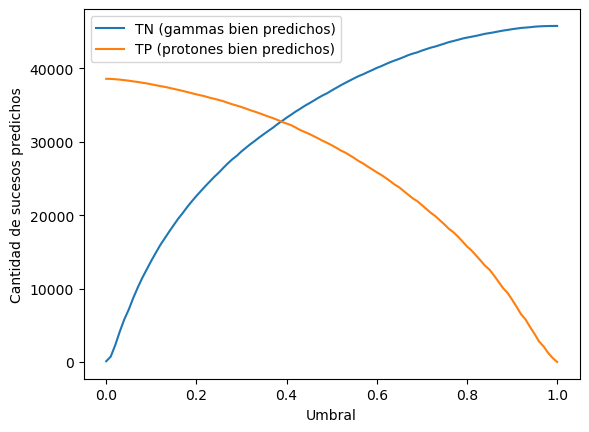

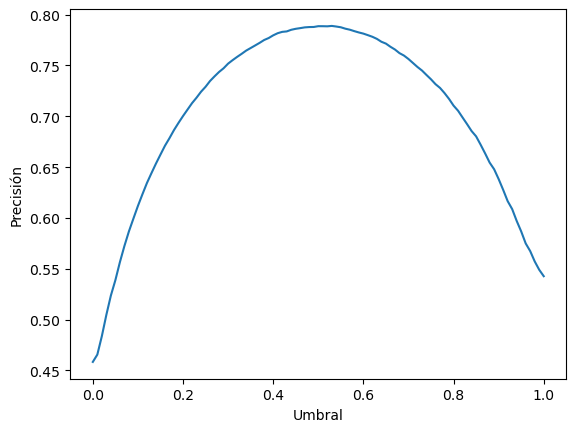

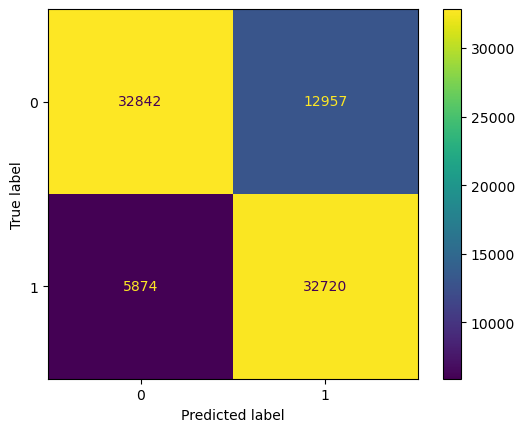

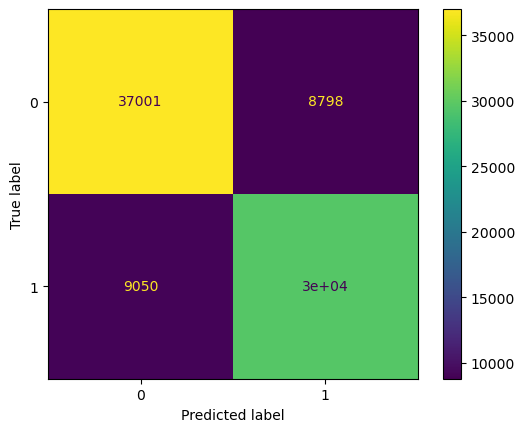

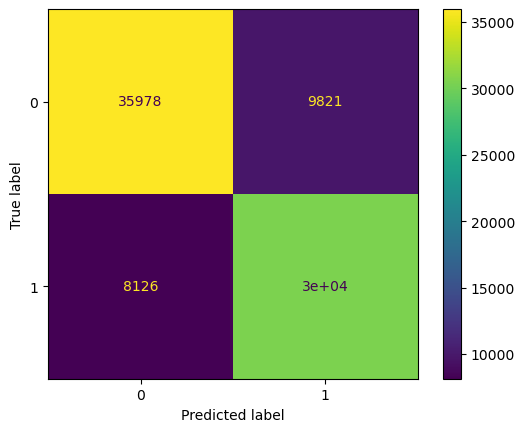

In [22]:
# Representamos los resultados para TP, FP, TN y FN
plt.plot(thresholds, TP, label = "TP")
plt.plot(thresholds, TN, label = "TN")
plt.plot(thresholds, FP, label = "FP")
plt.plot(thresholds, FN, label = "FN")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Distribución del clasificador RF
plt.plot(thresholds, TN, label = "TN (gammas bien predichos)")
plt.plot(thresholds, TP, label = "TP (protones bien predichos)")
plt.legend()
plt.xlabel("Umbral")
plt.ylabel("Cantidad de sucesos predichos")
plt.show()

# Representamos la precisión
plt.plot(thresholds, accuracy)
plt.xlabel("Umbral")
plt.ylabel("Precisión")
plt.show()

# Definimos el umbral que maximiza TP y TN y el que minimiza FP y FN:
thresholdmax = 0.39
thresholdmin = 0.50
thresholdroc = 0.47

# Comprobamos los resultados
y_pred = (rf.predict_proba(X_test)[:,1]>thresholdmax).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rf.predict_proba(X_test)[:,1]>thresholdmin).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rf.predict_proba(X_test)[:,1]>thresholdroc).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

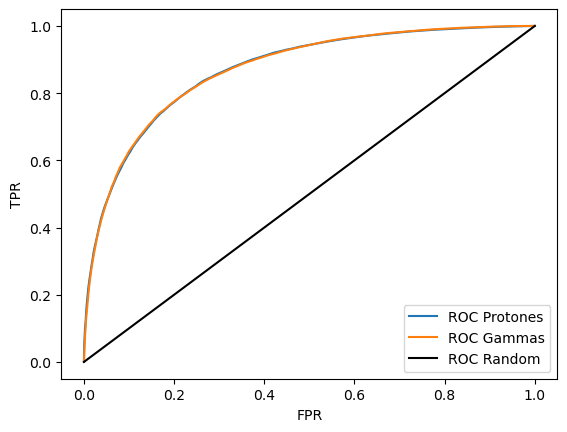

AUC para ROC de protones 0.8669998031746023
AUC para ROC de gammas 0.8690085806588269


In [25]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
plt.plot(FPRp, TPRp, label = "ROC Protones")
plt.plot(FPRg, TPRg, label = "ROC Gammas")
ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print('AUC para ROC de protones', auc(FPRp,TPRp))
print('AUC para ROC de gammas', auc(FPRg,TPRg))

Aquí están nuestros resultados finales del mejor RF Classifier que vamos a obtener.